In [1]:
import preloader as PreLoader
import notebookcfa27bdb31 as ArrayGenerator

Retrieving notices: ...working... done
- \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / 

In [2]:
preloader = PreLoader.PreLoader("vhr")

In [3]:
preloader.df.columns

Index(['name', 'date', 'status', 'rpm', 'bearing_abbs', 'standardized_faults',
       'report_name', 'zone', 'area', 'factory', 'type', 'ts_shape_no_nans'],
      dtype='object')

In [4]:
ts = preloader.get_3d_ts_array()
labels = preloader.get_labels_array("faults")

In [5]:
x, y = ArrayGenerator.generate_dataset_array(3, ts, labels, "channel")

{'Faults classified': 'Flow problem', 'Channels taken': 'Machine channels only', 'Labels array': 'Binary'}


In [6]:
x, y = ArrayGenerator.apply_sliding_window(x, y, 2048, 0.15, False)

In [7]:
!pip install tsai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.0 MB/s eta 0:00:00


In [8]:
from tsai.all import *

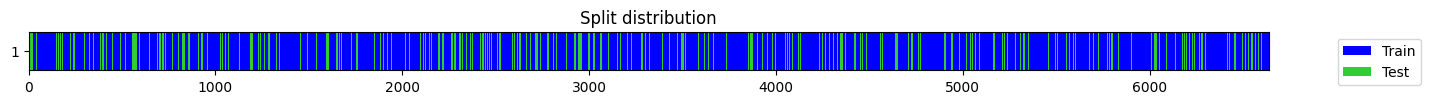

((#5684) [822,4497,6071,3371,3787,6499,5967,171,1789,4634...],
 (#1327) [356,753,4180,3392,3949,5935,5151,1887,4072,5844...])

In [9]:
splits = get_splits(y, valid_size=0.2, random_state=23, shuffle=True, balance=True)
splits

In [10]:
tfms = [None, [TSStandardize(by_var=True), Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(
    x,
    y,
    splits=splits,
    tfms=tfms,
    shuffle_train=True,
    batch_tfms=batch_tfms,
    bs=[64, 256],
)

In [11]:
del x
del y

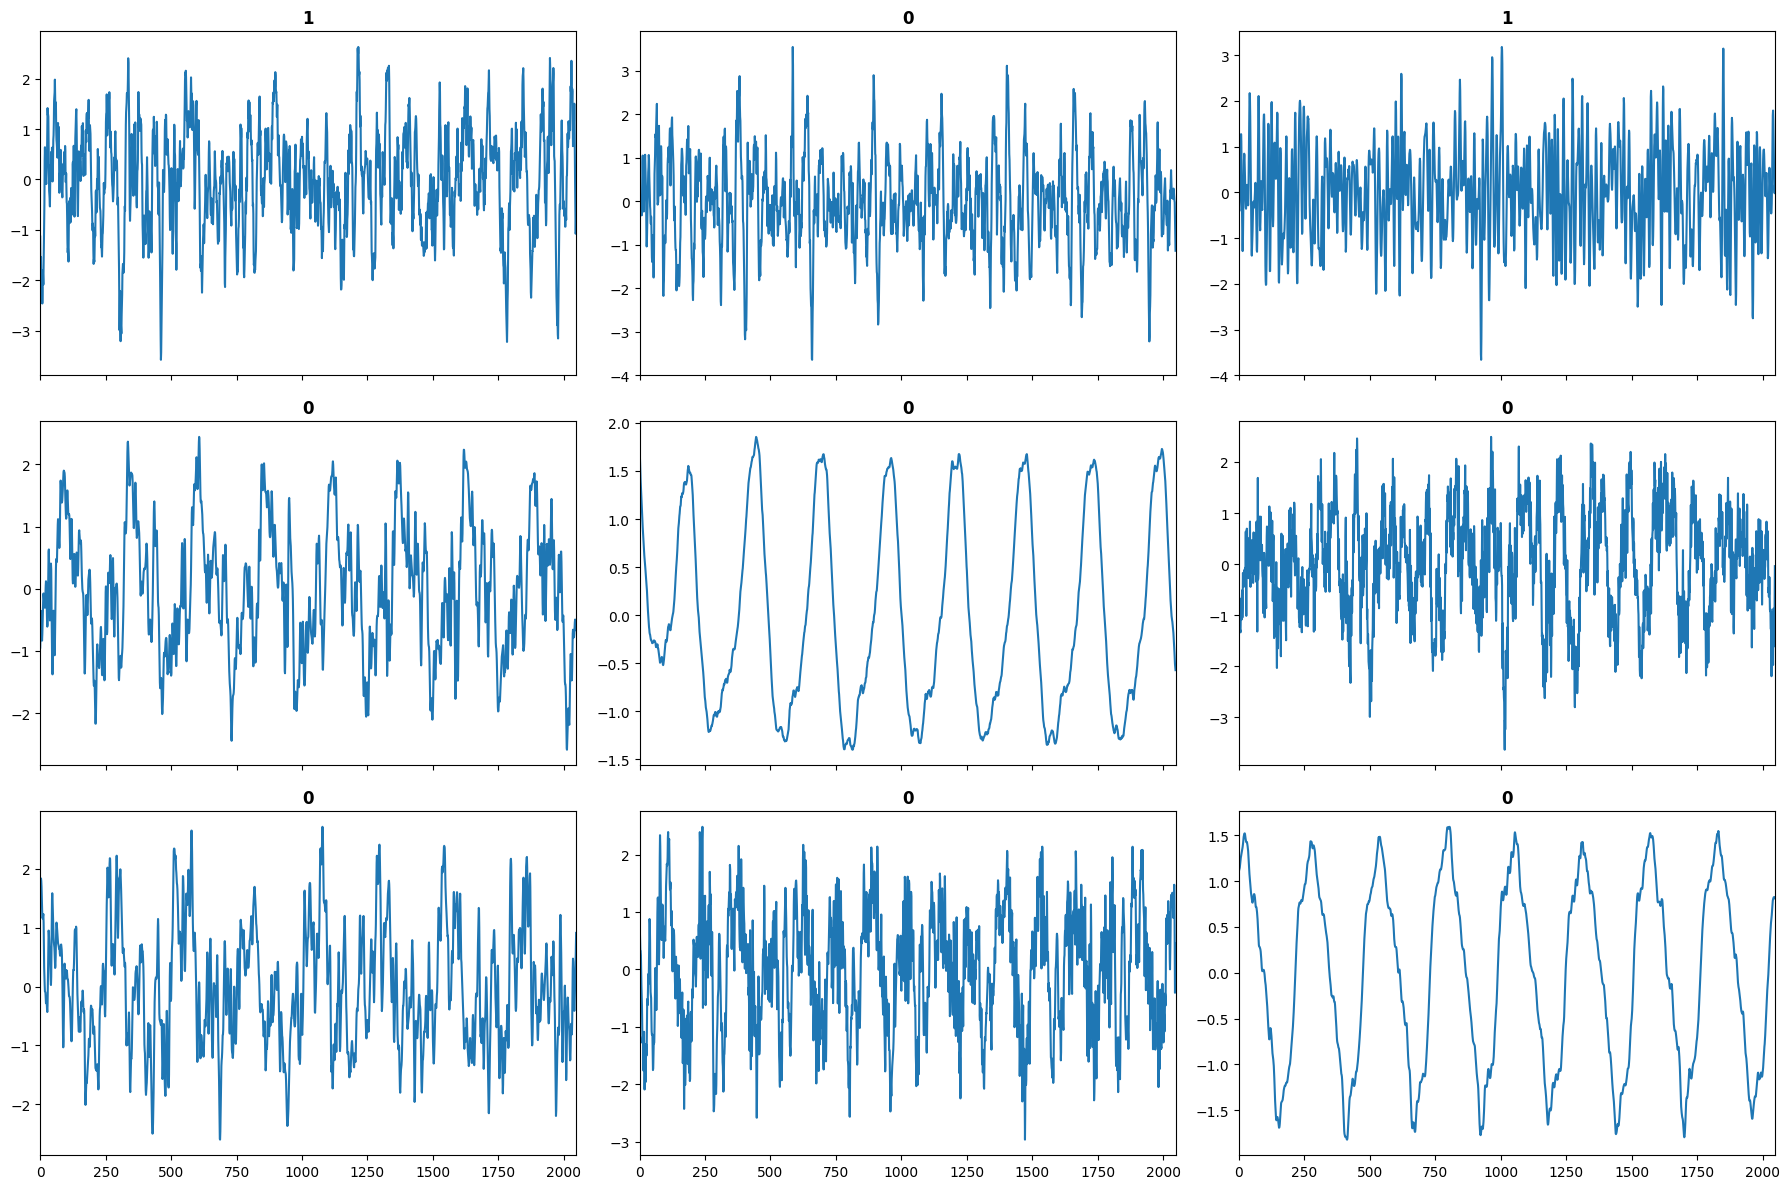

In [12]:
dls.show_batch(sharex=True)

In [13]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.610602,0.593067,0.669932,0.651111,0.825352,0.727950,00:19
1,0.572224,0.582687,0.700075,0.742991,0.671831,0.705621,00:19
2,0.540193,0.546109,0.731726,0.705336,0.856338,0.773537,00:19
3,0.515535,0.520870,0.769405,0.812693,0.739437,0.774336,00:19
4,0.487833,0.678259,0.627732,0.918605,0.333803,0.489669,00:20
5,0.474267,0.671116,0.693293,0.645533,0.946479,0.767561,00:20
6,0.445968,0.523871,0.743783,0.858527,0.623944,0.722675,00:20
7,0.426123,0.518078,0.747551,0.883436,0.608451,0.720601,00:20
8,0.400965,0.536853,0.730219,0.905530,0.553521,0.687063,00:20
9,0.362270,0.414020,0.804823,0.872727,0.743662,0.803042,00:20


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score
14,0.236286,0.32316,0.864356,0.856183,0.897183,0.876204


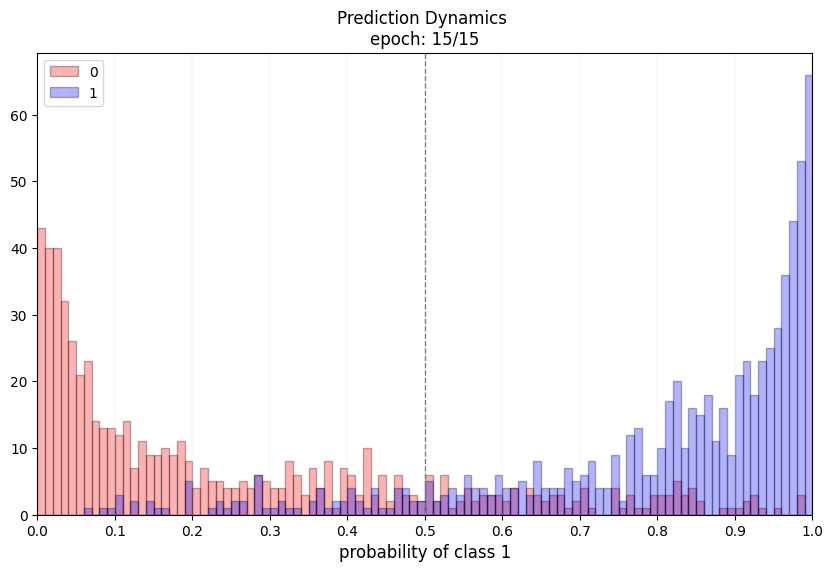

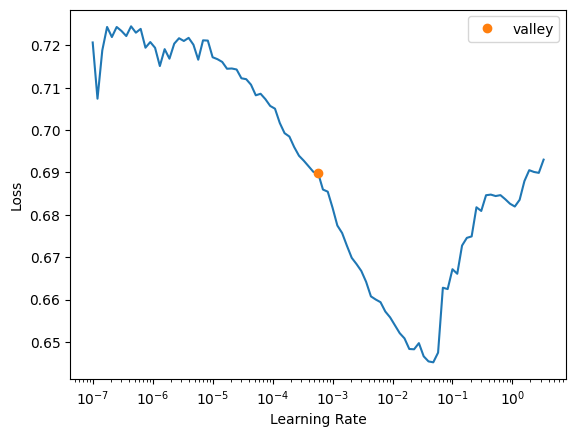

In [14]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=[PredictionDynamics()])

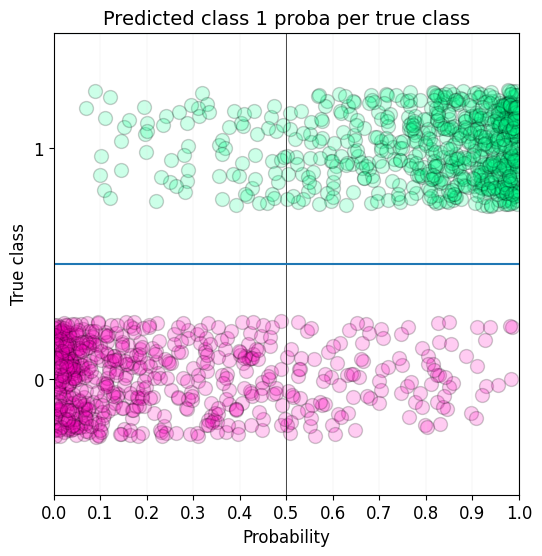

In [15]:
learn.show_probas()

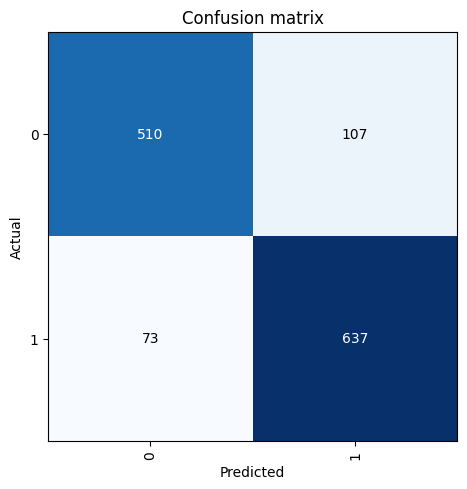

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [17]:
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)

In [18]:
positive_probs = valid_probas[:, 1]

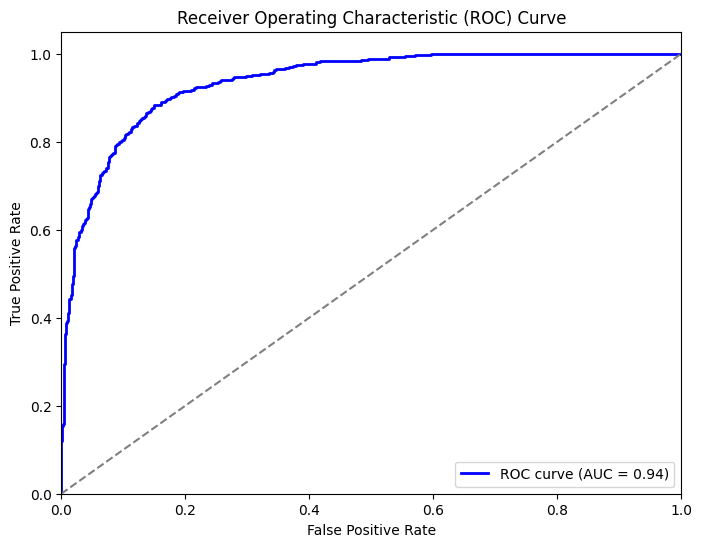

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [20]:
# We can calculate the optimum value for the threshold from the following code:
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.53231883


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

positive_probs = valid_probas[:, 1]

threshold = optimal_threshold  ###Adjust threshold if required. Use the optimal one found in the previous cell.

valid_preds_adjusted = (positive_probs > threshold).long()

accuracy = accuracy_score(valid_targets, valid_preds_adjusted)
precision = precision_score(valid_targets, valid_preds_adjusted)
recall = recall_score(valid_targets, valid_preds_adjusted)
f1 = f1_score(valid_targets, valid_preds_adjusted)

print("Adjusted Threshold Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Adjusted Threshold Metrics:
Accuracy: 0.8674
Precision: 0.8719
Recall: 0.8817
F1 Score: 0.8768


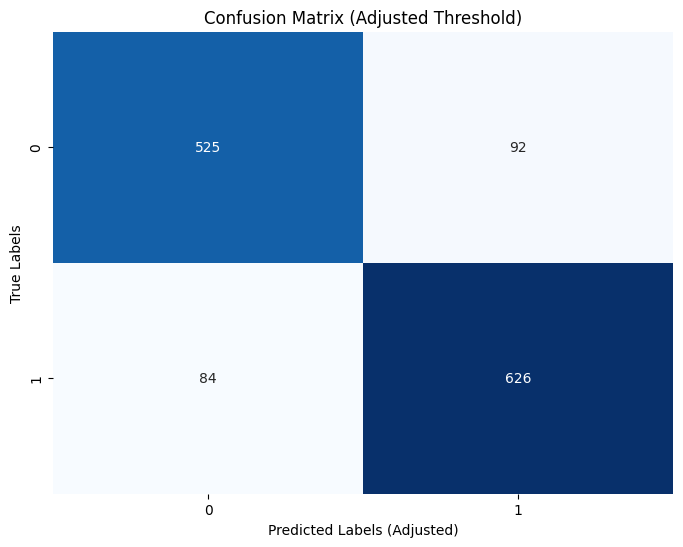

In [22]:
# Plot confusion matrix after adjsuting the threshold
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(valid_targets, valid_preds_adjusted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels (Adjusted)")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Adjusted Threshold)")
plt.show()